Implementing QAOA


In [2]:
#Import relevant packages
import numpy as np
import math
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister,QuantumRegister,QuantumCircuit
from qiskit import Aer, transpile, assemble, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.gate_map import plot_gate_map

from qiskit.providers.ibmq.managed import IBMQJobManager

provider = IBMQ.load_account()

#provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science')

/Users/robertbanks/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [6]:
#Define functions to create and solve Ising problems
def gen_ising(adj,local_t=False):
    #Create a hardware native spin glass of the form 
    # \sum_{i,j} J_{i,j} Z_i Z_j+h_i Z_i with J_{i,j} being 1 or -1 
    # from a numpy array or list of lists. Returns a numpy array

    adj=np.array(adj)
    compj=np.random.choice([-1,1],size=(len(adj),len(adj)))
    j=np.multiply(compj,adj)
    j=np.transpose(np.triu(j))+np.triu(j)

    if local_t:
        j=j+np.diag([np.random.choice([-1,0,1]) for value in np.diag(j)])
        

    return j


def solve_ising(adj):
    #Solve Ising by exhaustion
    n=len(adj)
    h=np.diag(adj)
    adj=np.array(adj/2)-np.diag(h)/2
    costs=[]

    for k in range(2**n):
        bits=list(format(k, '0'+str(n)+'b'))
        zeig=np.array([1-2*int(x) for x in bits])
        value=np.dot(zeig,np.dot(adj,zeig))+np.dot(np.array(h),zeig)
        costs.append(value)
        
    min_value=min(costs)
    place=[format(i, '0'+str(n)+'b') for i,j in enumerate(costs) if j == min_value]

    return {'energy':min_value,'string':place}

def energy(string, adj):
    n=len(adj)
    h=np.diag(adj)
    adj=np.array(adj/2)-np.diag(h)/2

    bits=list(string)
    zeig=np.array([1-2*int(x) for x in bits])
    value=np.dot(zeig,np.dot(adj,zeig))+np.dot(np.array(h),zeig)
    

    return {'energy':value,'string':string}

#Create circuit for the cost funtion
def circuit(adj,beta,gamma):
    n=len(adj)
    circ=QuantumCircuit(n,n)
    for i in range(n):
        circ.h(i)
        if np.diag(adj)[i]!=0:
            circ.rz(2*gamma*np.diag(adj)[i],i)

    for row,lis in enumerate(np.triu(adj,1)):
        for column,rot in enumerate(lis):
            if column > row and rot != 0:
                circ.p(gamma*rot,row)
                circ.p(gamma*rot,column)
                circ.cp(-2*gamma*rot,row,column)

    for i in range(n):
        circ.rx(2*beta,i)
        circ.measure(i,i)


    return circ

#Write code to run this circuit, this is our cost function.

def analysis(counts,adj,shots):
    
    avr_c=0
    min_c=[0,0]
    hist={}

    h=np.diag(adj)
    adj=np.array(adj/2)-np.diag(h)/2

    for sample in list(counts.keys()):
        x= np.array([1-2*int(num) for num in list(sample)])
        tmp_eng=np.dot(x,np.dot(adj,x))+np.dot(np.array(h),x)

        avr_c = avr_c + counts[sample]*tmp_eng
        hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]

        if( min_c[1] > tmp_eng):
            min_c[0] = sample
            min_c[1] = tmp_eng

    return {'histogram':hist, 'average':avr_c/shots, 'minimum': min_c}



def cost_function(beta,gamma, adj, shots=1024, device='qasm_simulator'):
    if device == 'qasm_simulator':
        backend=Aer.get_backend('qasm_simulator')
    else:
        backend = provider.get_backend(device)
    QAOA=circuit(adj,beta,gamma)
    TQAOA = transpile(QAOA, backend)
    qobj = assemble(TQAOA, shots=shots)
    job_exp = backend.run(qobj)
    #job_monitor(job_exp)
    QAOA_results=job_exp.result()
    expectation = analysis(QAOA_results.get_counts(),adj,shots)['average']
    
    return expectation 

    
#Create functions to explore gamma and beta
def exhaustive_search(adj,resolution=30,shots=1024,device='qasm_simulator'):
    step=list(range(resolution))
    dbeta=[b/resolution*math.pi for b in step]
    dgamma=[2*g/resolution*math.pi for g in step]
    

    if device == 'qasm_simulator':
        backend=Aer.get_backend('qasm_simulator')
        cost=[]
        for gvalue in dgamma:
             cost.append([cost_function(bvalue,gvalue,adj,shots=shots,device=device) for bvalue in dbeta])

    else:
        backend = provider.get_backend(device)


        circs=[circuit(adj,bvalue,gvalue) for bvalue in dbeta for gvalue in dgamma]

        

        job_manager = IBMQJobManager()
        job_set_foo = job_manager.run(circs, backend=backend,shots=shots, name='foo')

        results = job_set_foo.results()

        cost=[analysis(results.get_counts(k),adj,shots)['average'] for k in list(range(resolution**2))]
 
    cost=np.array(cost)
    cost=np.reshape(cost,(resolution,resolution))
    [m,n] = np.shape(cost)
    plt.figure()
    plt.imshow(cost, alpha=0.8)
    plt.xticks(np.arange(n))
    plt.yticks(np.arange(m))
    plt.xlabel('Numbers')
    plt.ylabel('Value')
    plt.title('Color Maps')
    plt.colorbar(label='Energy')
    plt.show()

    mini=np.min(cost)
    place=[(dbeta[m],dgamma[i]) for i,j in enumerate(cost) for m,n in enumerate(j) if n == mini]
    return {'angles':place, 'minimum':mini}



def gradient(adj,bi=0,gi=0,threshold=0.05,max_iterations=50,learning_rate=0.05,momentum=0,shots=1024, device='qasm_simulator'):
    i=0
    diff=1.0e10
    b=bi
    g=gi
    cbgn= cost_function(b,g,adj,shots=shots,device=device)

    while i<=max_iterations and diff>threshold:

       cbg=cbgn
       d = [cost_function(b+learning_rate,g,adj,shots=shots,device=device) - cbg,
       cost_function(b,g+learning_rate,adj,shots=shots, device=device) - cbg]
       delta=[-1*dvalue+momentum*dvalue for dvalue in d]
       b=b+delta[0]
       g=g+delta[1]
       cbgn= cost_function(b,g,adj,shots=shots,device=device)
       i=i+1
       diff=np.abs(cbg-cbgn)

    return{'angles':[(b,g)], 'minimum':cbgn}

def QAOAp1(adj, search='exhaustive', shots=1024, beta_in=0,gamma_in=0, device='qasm_simulator'):
    if search == 'exhaustive':
        qaoa=exhaustive_search(adj,shots=shots, device=device)
    elif search == 'gradient':
        qaoa=gradient(adj,bi=beta_in, gi=gamma_in,shots=shots, device=device)

    if device == 'qasm_simulator':
        backend=Aer.get_backend('qasm_simulator')
    else:
        backend = provider.get_backend(device)
    beta, gamma=qaoa['angles'][0]
    QAOA=circuit(adj,beta,gamma)
    TQAOA = transpile(QAOA, backend)
    qobj = assemble(TQAOA, shots=shots)
    QAOA_results = backend.run(qobj).result()
    out=analysis(QAOA_results.get_counts(),adj,shots)
    out['angles']=[beta,gamma]

    return out
    
def physical(device='least busy',qubits=5,shots=2048):
    if device=='least busy':
        small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == qubits
                                   and not x.configuration().simulator)
        backend=least_busy(small_devices)

    else:
        backend=provider.get_backend(device)

    config = backend.configuration()
    n_qubits = int(config.n_qubits)
    cmap = config.coupling_map
    con=np.zeros((n_qubits,n_qubits))
    for connection in cmap:
        con[connection[0],connection[1]]=1

    isin=gen_ising(con,True)
    solution=solve_ising(isin)

    angles=QAOAp1(isin,search='exhaustive',shots=shots)['angles']

    out=QAOAp1(isin, search='gradient',shots=shots, beta_in=angles[0],gamma_in=angles[1],device=backend.name())
    out['initial angles']=angles
    out['backend']=backend.name()
    out['problem']=isin
    out['solution']=solution

    return out


def planted_solution(network,loop_min=4, loop_max=100,  number_of_loops=10,scale=1):
    
    n=len(network)
    solution_str=np.random.randint(2**n)
    solution_str=format(solution_str, '0'+str(n)+'b')
    solution=list(solution_str)
    loop_number=0

    ising=np.zeros((n,n))

    while loop_number<number_of_loops:
        path=[]
        ising_local=np.zeros((n,n))
        #Choose initial value
        path.append(np.random.choice(list(range(len(network)))))

        #Create path until it collides with it self
        while len(path)==len(set(path)):
            path.append(np.random.choice(network[str(path[-1])]))

        #Remove the tails and allow for length selction
        start=[k for k, y in enumerate(path) if y==path[-1]]
        loop=[x for ii, x in enumerate(path) if ii>= start[0]]

        loop_record=[]

        if loop_min<len(loop)<loop_max and not(loop in loop_record):
            #Set Ising parameters
            loop_record=loop_record.append(loop)
            for k, connection in enumerate(loop[:-1]):
                con_bit=loop[k+1]
                if solution[connection]==solution[con_bit]:
                    ising_local[connection][con_bit]=-1
                else:
                    ising_local[connection][con_bit]=1
            #Create frustration
            flip=np.random.randint(len(loop)-1)
            ising_local[loop[flip]][loop[flip+1]]=ising_local[loop[flip]][loop[flip+1]]*-1

            #Update the ising model and counter
            ising=ising+ising_local
            loop_number=loop_number+1

    ising=ising+np.transpose(ising)

    if scale:
        maxValue=np.amax(np.absolute(ising))
        ising=ising/maxValue*scale

    return{'solution':solution_str,'ising_model':ising}


    


In [ ]:
print(physical(shots=1024))

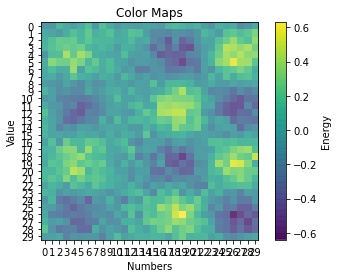

{'histogram': {'-1': 169, '0': 158, '1': 175, '5': 29, '-7': 21, '-4': 92, '4': 61, '-3': 139, '3': 109, '-5': 52, '-8': 8, '7': 10, '8': 1}, 'average': -0.4375000000000003, 'minimum': ['000101011001110100111011', -8.0], 'angles': [2.7227136331111543, 5.445427266222309]}


In [14]:
chimera32={'0':[4,5,6,7,16],'1':[4,5,6,7,17],'2':[4,5,6,7,18],'3':[4,5,6,7,19],'4':[0,1,2,3,12],'5':[0,1,2,3,13],'6':[0,1,2,3,14],'7':[0,1,2,3,15],
'8':[12,13,14,15,24],'9':[12,13,14,15,25],'10':[12,13,14,15,26],'11':[12,13,14,15,27],'12':[8,9,10,11,4],'13':[8,9,10,11,5],'14':[8,9,10,11,6],'15':[8,9,10,11,7],
'16':[20,21,22,23,0],'17':[20,21,22,23,1],'18':[20,21,22,23,2],'19':[20,21,22,23,3],'20':[16,17,18,19,28],'21':[16,17,18,19,29],'22':[16,17,18,19,30],'23':[16,17,18,19,31],
'24':[28,29,30,31,8],'25':[28,29,30,31,9],'26':[28,29,30,31,10],'27':[28,29,30,31,11],'28':[24,25,26,27,20],'29':[24,25,26,27,21],'30':[24,25,26,27,22],'31':[24,25,26,27,23]}

chimera24={'0':[4,5,6,7,16],'1':[4,5,6,7,17],'2':[4,5,6,7,18],'3':[4,5,6,7,19],'4':[0,1,2,3,12],'5':[0,1,2,3,13],'6':[0,1,2,3,14],'7':[0,1,2,3,15],
'8':[12,13,14,15],'9':[12,13,14,15],'10':[12,13,14,15],'11':[12,13,14,15],'12':[8,9,10,11,4],'13':[8,9,10,11,5],'14':[8,9,10,11,6],'15':[8,9,10,11,7],
'16':[20,21,22,23,0],'17':[20,21,22,23,1],'18':[20,21,22,23,2],'19':[20,21,22,23,3],'20':[16,17,18,19],'21':[16,17,18,19],'22':[16,17,18,19],'23':[16,17,18,19]}


unit_cell={'0':[4,5,6,7],'1':[4,5,6,7],'2':[4,5,6,7],'3':[4,5,6,7],'4':[0,1,2,3],'5':[0,1,2,3],'6':[0,1,2,3],'7':[0,1,2,3]}


ising_test=planted_solution(chimera24)
print(QAOAp1(ising_test['ising_model'],device='ibmq_qasm_simulator'))

In [15]:
print(energy(ising_test['solution'],ising_test['ising_model']))


{'energy': -9.333333333333332, 'string': '101011101010111000001011'}


In [ ]:
#Create circuit for the cost funtion
def circuit(adj,beta,gamma):
    n=len(adj)
    circ=QuantumCircuit(n,n)
    for i in range(n):
        circ.h(i)
        if np.diag(adj)[i]!=0:
            circ.rz(2*gamma*np.diag(adj)[i],i)

    for row,lis in enumerate(np.triu(adj,1)):
        for column,rot in enumerate(lis):
            if column > row and rot != 0:
                circ.p(gamma*rot,row)
                circ.p(gamma*rot,column)
                circ.cp(-2*gamma*rot,row,column)

    for i in range(n):
        circ.rx(2*beta,i)
        circ.measure(i,i)


    return circ




In [ ]:
backend = provider.get_backend('ibmq_qasm_simulator')
backend.


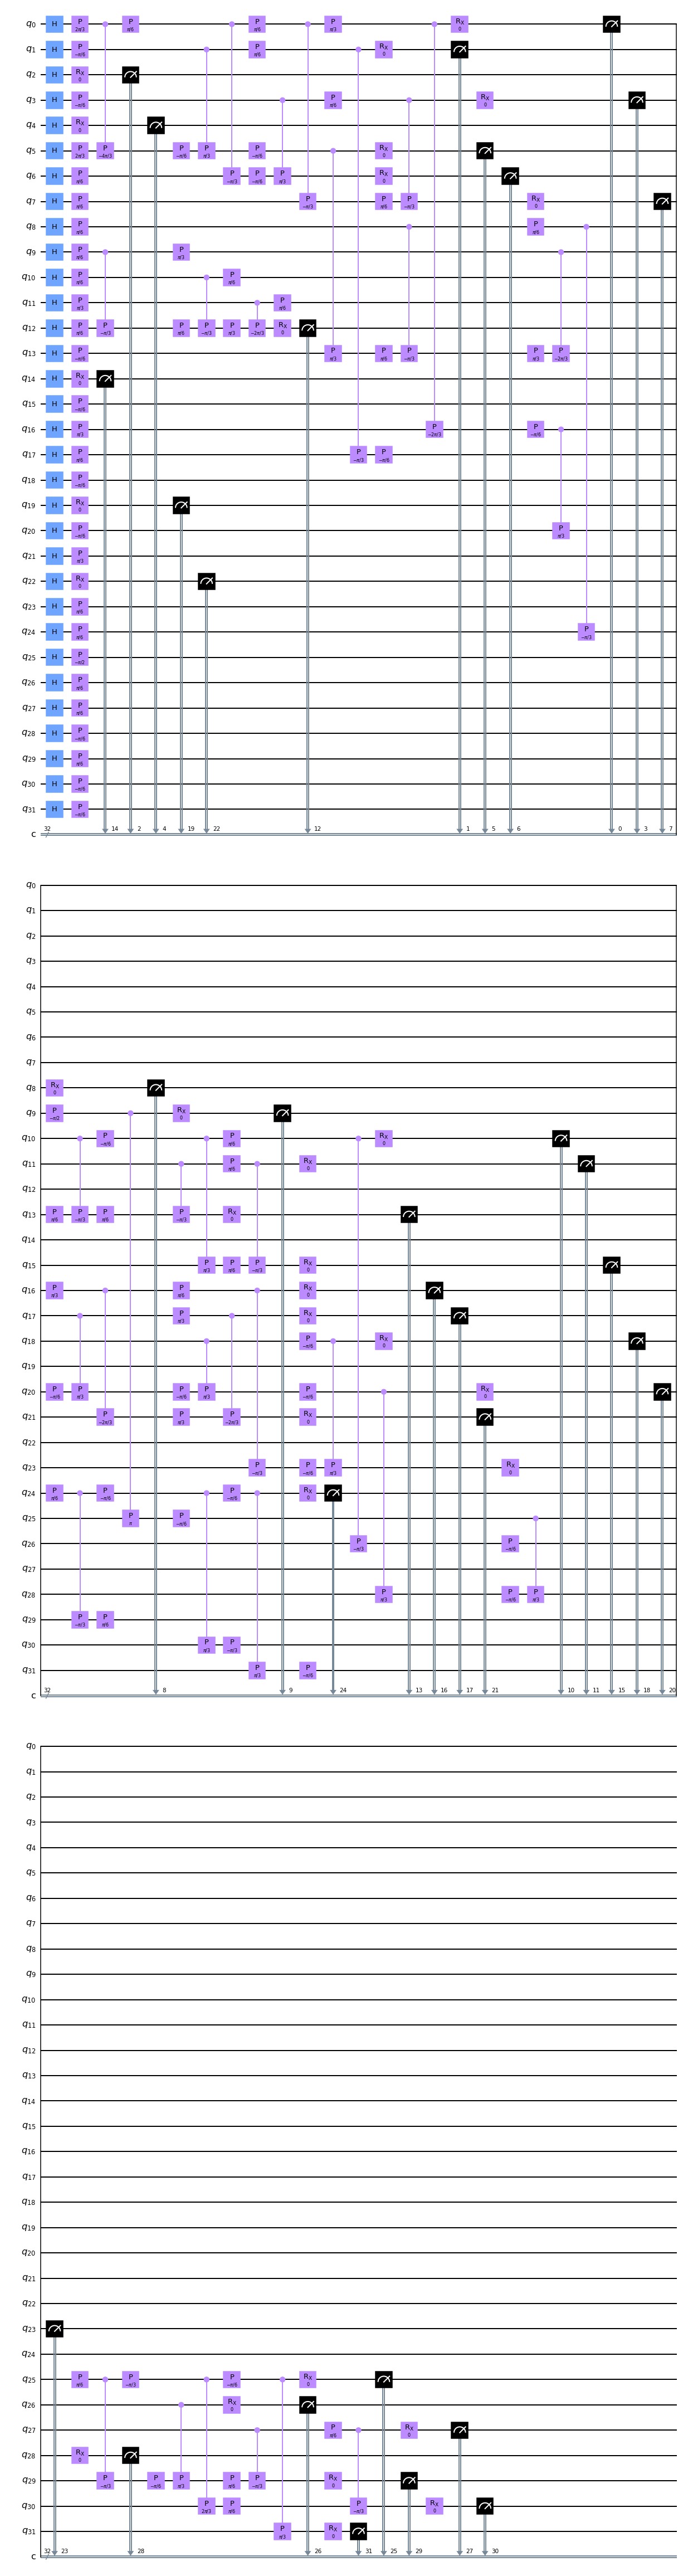

In [13]:
step=list(range(30))
dbeta=[b/30*math.pi for b in step]
dgamma=[2*g/30*math.pi for g in step]

    
backend = provider.get_backend('ibmq_qasm_simulator')


circs=[circuit(planted_solution(chimera32)['ising_model'],bvalue,gvalue) for bvalue in dbeta for gvalue in dgamma]

        

circs = transpile(circs, backend=backend)
circs[10].draw(output='mpl')

In [ ]:
#Write code to run this circuit, this is our cost function.

def analysis(results,adj,shots):
    counts=results.get_counts()
    avr_c=0
    min_c=[0,0]
    hist={}

    h=np.diag(adj)
    adj=np.array(adj/2)-np.diag(h)/2

    for sample in list(counts.keys()):
        x= np.array([1-2*int(num) for num in list(sample)])
        tmp_eng=np.dot(x,np.dot(adj,x))+np.dot(np.array(h),x)

        avr_c = avr_c + counts[sample]*tmp_eng
        hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]

        if( min_c[1] > tmp_eng):
            min_c[0] = sample
            min_c[1] = tmp_eng

    return {'histogram':hist, 'average':avr_c/shots, 'minimum': min_c}



def cost_function(beta,gamma, adj, shots=1024, device='qasm_simulator'):
    if device == 'qasm_simulator':
        backend=Aer.get_backend('qasm_simulator')
    else:
        backend = provider.get_backend(device)
    QAOA=circuit(adj,beta,gamma)
    TQAOA = transpile(QAOA, backend)
    qobj = assemble(TQAOA, shots=shots)
    job_exp = backend.run(qobj)
    #job_monitor(job_exp)
    QAOA_results=job_exp.result()
    expectation = analysis(QAOA_results,adj,shots)['average']
    
    return expectation 

    

In [ ]:
#Create functions to explore gamma and beta
def exhaustive_search(adj,resolution=30,shots=1024,device='qasm_simulator'):
    step=list(range(resolution))
    dbeta=[b/resolution*math.pi for b in step]
    dgamma=[2*g/resolution*math.pi for g in step]
    cost=[]
    for gvalue in dgamma:
        cost.append([cost_function(bvalue,gvalue,adj,shots=1024,device=device) for bvalue in dbeta])
    
    cost=np.array(cost)
    [m,n] = np.shape(cost)
    plt.figure()
    plt.imshow(cost, alpha=0.8)
    plt.xticks(np.arange(n))
    plt.yticks(np.arange(m))
    plt.xlabel('Numbers')
    plt.ylabel('Value')
    plt.title('Color Maps')
    plt.colorbar(label='Energy')
    plt.show()

    mini=np.min(cost)
    place=[(dbeta[m],dgamma[i]) for i,j in enumerate(cost) for m,n in enumerate(j) if n == mini]
    return {'angles':place, 'minimum':mini}



def gradient(adj,bi=0,gi=0,threshold=0.000001,max_iterations=500,learning_rate=0.005,momentum=0,shots=1024, device='qasm_simulator'):
    i=0
    diff=1.0e10
    b=bi
    g=gi
    cbgn= cost_function(b,g,adj,shots=shots,device=device)

    while i<=max_iterations and diff>threshold:

       cbg=cbgn
       d = [cost_function(b+learning_rate,g,adj,shots=shots,device=device) - cbg,
       cost_function(b,g+learning_rate,adj,shots=shots, device=device) - cbg]
       delta=[-1*dvalue+momentum*dvalue for dvalue in d]
       b=b+delta[0]
       g=g+delta[1]
       cbgn= cost_function(b,g,adj,shots=shots,device=device)
       i=i+1
       diff=np.abs(cbg-cbgn)

    return{'angles':[(b,g)], 'minimum':cbgn}

In [ ]:
cas=[[0,1,0,0,0,0,0],
     [1,0,1,1,0,0,0],
     [0,1,0,0,0,0,0],
     [0,1,0,0,0,1,0],
     [0,0,0,0,0,1,0],
     [0,0,0,1,1,0,1],
     [0,0,0,0,0,1,0]]
mat=gen_ising(np.array(cas),True)
print(mat)
print(solve_ising(mat))


In [ ]:
backend=provider.get_backend('ibmq_casablanca')
qc=circuit(mat,1,3)
qc.draw(output='mpl')







In [ ]:
transpile(qc,backend)
qc.draw(output='mpl')

In [ ]:
def QAOAp1(adj, search='exhaustive', shots=1024, beta_in=0,gamma_in=0, device='qasm_simulator'):
    if search == 'exhaustive':
        qaoa=exhaustive_search(adj,shots=shots, device='qasm_simulator')
    elif search == 'gradient':
        qaoa=gradient(adj,bi=beta_in, gi=gamma_in,shots=shots, device='qasm_simulator')

    if device == 'qasm_simulator':
        backend=Aer.get_backend('qasm_simulator')
    else:
        backend = provider.get_backend(device)
    beta, gamma=qaoa['angles'][0]
    QAOA=circuit(adj,beta,gamma)
    TQAOA = transpile(QAOA, backend)
    qobj = assemble(TQAOA, shots=shots)
    QAOA_results = backend.run(qobj).result()
    out=analysis(QAOA_results,adj,shots)
    out['angles']=[beta,gamma]

    return out
    


In [ ]:
print(QAOAp1(mat,search='gradient',shots=2048))
print(solve_ising(mat))

In [ ]:
#Run on an actual IBM device
#Select least busy device 

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend=least_busy(small_devices)

print(backend.name())

config = backend.configuration()
n_qubits = int(config.n_qubits)
cmap = config.coupling_map
con=np.zeros((n_qubits,n_qubits))
for connection in cmap:
    con[connection[0],connection[1]]=1

plot_gate_map(backend)

backend=Aer.get_backend('ibmq_casablanca')

In [ ]:
#Generate Ising device
isin=gen_ising(con,True)
print(isin)

#Solve and print Ising problem
solution=solve_ising(isin)
print(solution)

In [ ]:
print(QAOAp1(isin,search='gradient',shots=2048))





In [ ]:
def physical(shots=2048):
    small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
    backend=least_busy(small_devices)

    config = backend.configuration()
    n_qubits = int(config.n_qubits)
    cmap = config.coupling_map
    con=np.zeros((n_qubits,n_qubits))
    for connection in cmap:
        con[connection[0],connection[1]]=1

    isin=gen_ising(con,True)
    solution=solve_ising(isin)

    angles=QAOAp1(isin,search='exhaustive',shots=2048)['angles']

    out=QAOAp1(isin, search='gradient',shots=2048, beta_in=angles[0],gamma_in=angles[1],device=backend.name())
    out['initial angles']=angles
    out['backend']=backend.name()
    out['problem']=isin
    out['solution']=solution

    return out


    

    

In [ ]:
print(physical())